In [172]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
import os

# Change the working directory to one level higher
if not os.getcwd().endswith('tqs_unitaries'):
    os.chdir('..')

In [174]:
from model import TransformerModel
from Hamiltonian import Ising, IsingY, XYZ
from Hamiltonian_utils import dec2bin
from model_utils import compute_psi
import numpy as np
import torch
import matplotlib.pyplot as plt

Most recent plain run: YFIELD-39

In [175]:
system_sizes = np.arange(10, 41, 2).reshape(-1, 1)
hamiltonian_class = Ising
Hamiltonians = [hamiltonian_class(system_size_i, periodic=False) for system_size_i in system_sizes]

param_dim = Hamiltonians[0].param_dim
embedding_size = 32
n_head = 8
n_hid = embedding_size
n_layers = 8
dropout = 0
minibatch = 10000
eval_system_size = torch.tensor([12])
eval_param = torch.tensor([1.0])

model = TransformerModel(
    system_sizes,
    param_dim,
    embedding_size,
    n_head,
    n_hid,
    n_layers,
    dropout=dropout,
    minibatch=minibatch,
)

model.load_state_dict(torch.load("results-plain-noninverted/ckpt_2200_Ising_32_8_8_0.ckpt"))
model.eval()

n = eval_system_size.prod().item()
model.set_param(eval_system_size, eval_param)

/home/spandan/Projects/tqs_unitaries/Hamiltonian_utils.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  system_size = torch.tensor(system_size, dtype=torch.int64).reshape(-1)
/home/spandan/Projects/tqs_unitaries/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [176]:
all_dec = torch.arange(2**n, dtype=torch.int64)
all_configs = dec2bin(all_dec, n).T  # (n, 2^n)
all_configs[:, 0], all_configs[:, -1]

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [177]:
Hamiltonians[1].system_size

tensor([12])

In [178]:
with torch.no_grad():
    symm = Hamiltonians[1].symmetry
    log_amp, log_phase = compute_psi(model, all_configs, check_duplicate=False, symmetry=symm)

log_phase = log_phase - log_phase.mean()

log_amp.exp().sum(), log_phase.mean()

(tensor(1.), tensor(6.4261e-08))

In [179]:
def reproduce_psi(log_amp: torch.Tensor, log_phase: torch.Tensor) -> torch.Tensor:
    """
    Produces full imaginary wave function pointwise as a function of log_amps
    and log_phases, as output by the TQS model.
    """

    return torch.sqrt(log_amp.exp()) * torch.exp(1j * log_phase)

In [180]:
psi = reproduce_psi(log_amp, log_phase)
psi.conj() @ psi

tensor(1.0000+0.j)

tensor(1.0000)


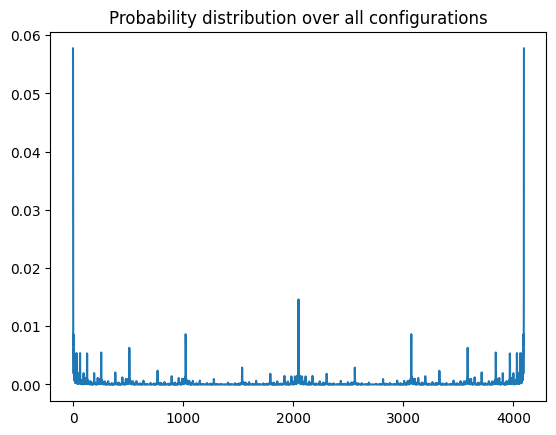

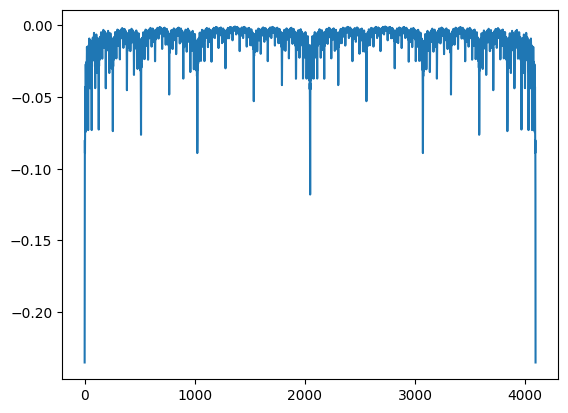

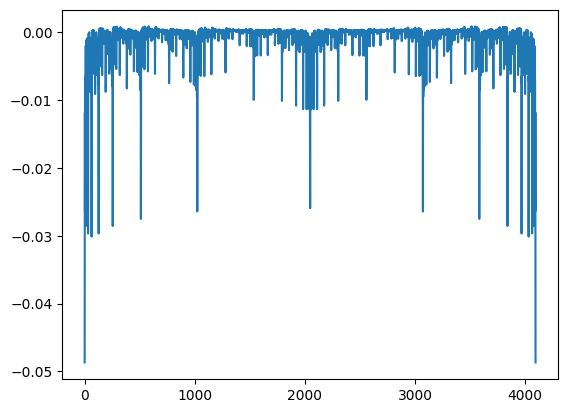

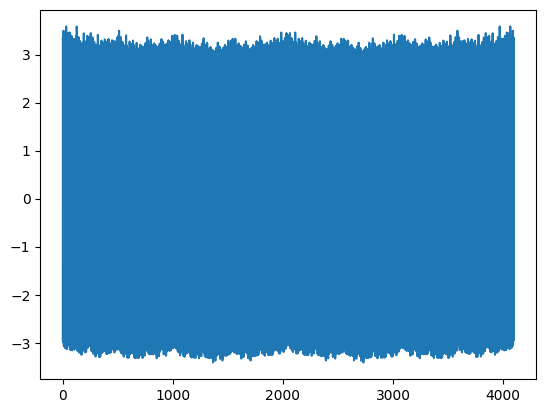

In [181]:
probs = (psi.conj() * psi).real
print(probs.sum())
plt.plot(probs)
plt.title("Probability distribution over all configurations")
plt.show()
plt.plot(psi.real)
plt.show()
plt.plot(psi.imag)
plt.show()
plt.plot(log_phase)

In [182]:
psi.real.T @ psi.imag

tensor(0.1541)

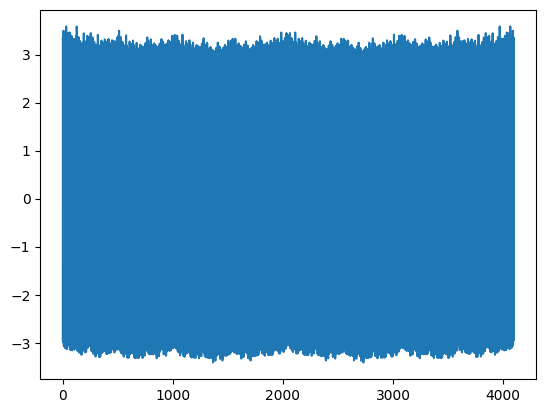

In [183]:
plt.plot(log_phase.numpy())

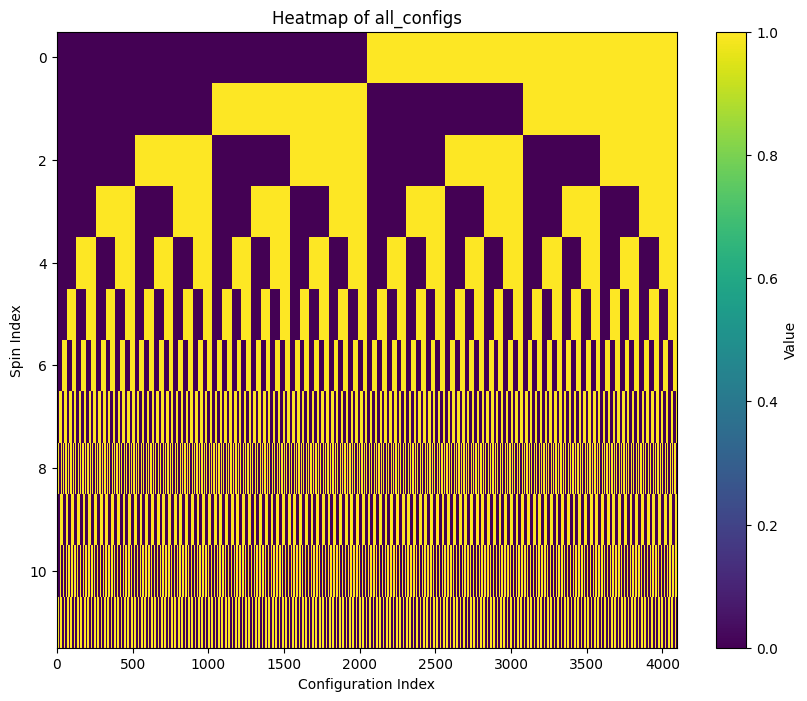

In [184]:
plt.figure(figsize=(10, 8))
plt.imshow(all_configs.numpy(), aspect='auto', cmap='viridis', interpolation="none")
plt.colorbar(label='Value')
plt.xlabel('Configuration Index')
plt.ylabel('Spin Index')
plt.title('Heatmap of all_configs')
plt.show()

In [185]:
all_configs[:, 0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])